In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
file_ = "data/boston.csv"
try: # Running Locally
    df = pd.read_csv(file_)
except: # Running in Google Colab
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/ptpjb/main/{file_}
    df = pd.read_csv("data/real_17.csv")

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
# Menentukan variabel target dan input
y = df[['PRICE']].values
X = df.drop(columns=['PRICE']).values

# Check the shape of training data
print(X.shape,y.shape)
print(type(y),type(X))

(506, 13) (506, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [4]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('Banyak data train:', len(X_train))
print('Banyak data test :', len(X_test))

Banyak data train: 354
Banyak data test : 152


In [5]:
# feature scalling
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(X_train)
scaler2 = MinMaxScaler()
scaler2.fit(y_train)

X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)
y_train_scaled = scaler2.transform(y_train)
y_test_scaled = scaler2.transform(y_test)

In [6]:
# Membuat fungsi model neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_model(neurons_1=16, neurons_2=10):
    # create model
    model = Sequential()
    model.add(Dense(neurons_1, input_dim=13, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [7]:
# Cek summary model default
model = create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Membuat model dengan KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor

# Early Stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = "min", patience = 5, verbose = 0)

# create model
model = KerasRegressor(build_fn=create_model, epochs=500, validation_split=0.1, batch_size=32, callbacks=[es], verbose=0)

In [9]:
# Menentukan parameter-paramater untuk melakukan grid search

neurons_1 = [16, 32, 64]
neurons_2 = [10, 20, 30]
param_grid = dict(neurons_1=neurons_1, neurons_2=neurons_2)

In [10]:
# Membuat model dengan GridSearchCV

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [11]:
# Training model
grid_result = grid.fit(X_train_scaled, y_train_scaled)

In [12]:
# Memilih model terbaik

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
best_model = grid_result.best_estimator_.model
history = best_model.history

Best: -0.010773 using {'neurons_1': 64, 'neurons_2': 10}


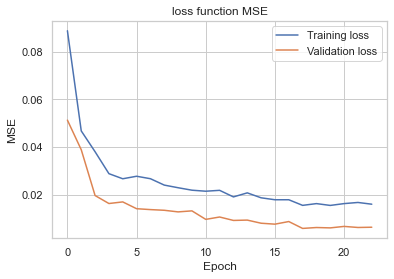

In [13]:
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

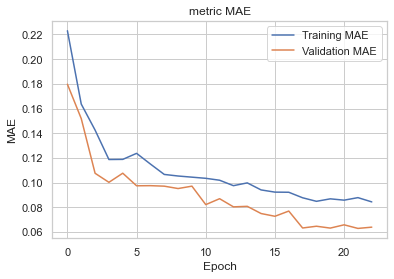

In [14]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

MAE data test sebesar: 3.2088665297156886


<AxesSubplot:>

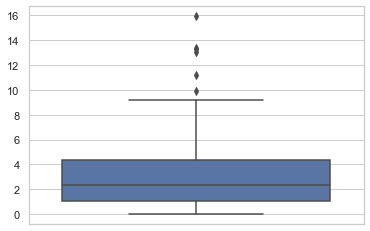

In [15]:
# Evaluasi model dengan data test

y_pred = best_model.predict(X_test_scaled)
y_pred = scaler2.inverse_transform(y_pred)

abs_error = np.abs(y_test-y_pred)

# Mean Absolute Error (MAE) test data
mae = np.mean(abs_error)
print('MAE data test sebesar:', mae)

sns.boxplot(y = abs_error)

In [16]:
# save model
best_model.save('reg_deploy/NN_reg')

# save scaler
import pickle
pickle.dump(scaler1, open('reg_deploy/scalerX.pkl', 'wb'))
pickle.dump(scaler2, open('reg_deploy/scalerY.pkl', 'wb'))

INFO:tensorflow:Assets written to: reg_deploy/NN_reg\assets
